In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, recall_score, balanced_accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

# Reading, Preprocessing and EDA

In [27]:
directory = "../datasets/Datasets_Healthy_Older_People/S2_Dataset"
cnt = 0
train_df = pd.DataFrame()
for filename in os.scandir(directory):
    while(cnt<27):
        df = pd.read_csv(filename, header = None)
        cnt+=1
        train_df = pd.concat([train_df, df])
print(train_df.shape,"in", cnt, "files.")
print("done")

(3159, 9) in 27 files.
done


Dataset has no null or object values.

In [28]:
print(train_df.isnull().sum().sum(), train_df.isna().sum().sum())

0 0


In [29]:
list_dtype = [train_df[i].dtype for i in train_df.columns]
print(dict((i, list_dtype.count(i)) for i in list_dtype))

{dtype('float64'): 7, dtype('int64'): 2}


In [30]:
train_df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [31]:
train_df[8] = train_df[8].apply(lambda v: 1 if v == 3 else 0)

In [32]:
train_df[8].value_counts()

1    2592
0     567
Name: 8, dtype: int64

In [33]:
label_encoder = LabelEncoder()
train_df[8] = label_encoder.fit_transform(train_df[8])    

In [34]:
train_df[8].value_counts()

1    2592
0     567
Name: 8, dtype: int64

In [35]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
scl.fit(train_df)
scl.transform(train_df)
train_df, test_df = train_test_split(train_df, train_size = 0.9, random_state = 42) 
y_train = train_df[8]
y_test = test_df[8]
X_train = train_df.drop([8], axis = 1)
X_test = test_df.drop([8], axis = 1)

In [36]:
y_test.value_counts()

1    270
0     46
Name: 8, dtype: int64

In [37]:
class CentroidSMOTE():
    def __init__(self, sampling_strategy='auto', random_state=42, k_neighbors=5, m_vertices=3):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.k_neighbors = k_neighbors
        self.m_vertices = m_vertices
    
    @staticmethod
    def nearest_neighbor(X, k):
        from sklearn.neighbors import NearestNeighbors
        nbs=NearestNeighbors(n_neighbors=k+1,metric='euclidean',algorithm='kd_tree').fit(X)
        euclidean,indices= nbs.kneighbors(X)
        return indices[:, 1:]
    
    def fit_resample(self, X, y):
        
        (unique, freq) = np.unique(y, return_counts=True)
        frequency = dict(zip(unique, freq))
        max_frequency = max(frequency.values())
        
        if self.sampling_strategy == 'auto':
            sampling_strategy = {}
            for (key, value) in frequency.items():
                sampling_strategy[key] = max_frequency - value
            self.sampling_strategy = sampling_strategy
            
        data = {}
        for (key, value) in self.sampling_strategy.items():
            if value == 0:
                continue
            X_small = X[y == key]
            indices = self.nearest_neighbor(X_small, self.k_neighbors)
            new_data = []
            for idx in np.random.choice(np.arange(len(X_small)), size=value):
                p = X_small[idx]
                nnarray = indices[idx]
                q = X_small[np.random.choice(nnarray, size=self.m_vertices-1, replace=False)]
                new_data.append(np.sum(np.vstack([p, q]), axis=0)/self.m_vertices)
            X_new = np.vstack(new_data)
            data[key] = X_new
        
        for (key, value) in data.items():
            X = np.vstack([X, value])
            y = np.concatenate([y, np.ones(len(value))*key])
        
        X, y = shuffle(X, y, random_state=self.random_state)
        
        return X, y        

In [38]:
def score(X_test, y_test, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {acc:.6f}")
    print(f"Error Rate: {1-acc}")
    Recall = recall_score(y_test, y_pred, average='macro')      
    print(f"Mean Recall: {Recall}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
    Array_prec_recall_f = precision_recall_fscore_support(y_test, y_pred, average='macro')
#                                                                         average = 'micro', 'macro', 'weighted'
    print(f"Precision: {Array_prec_recall_f[0]}")
    print(f"F-Score: {Array_prec_recall_f[2]}")
          
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    print(len(y_pred), len(y_test))
    for i in range(len(y_pred)): 
        if y_test[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_test[i]!=y_pred[i]:
           FP += 1
        if y_test[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    if TN + FP == 0: 
      Selectivity = 0
    else:
      Selectivity = TN/(TN + FP)
    G_mean = np.sqrt(Selectivity*Recall) 
    print(f"Selectivity: {Selectivity}") 
    print(f"G_mean: {G_mean}")   
    
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   
        

In [39]:
pipeline = Pipeline([
    ('classifier', KNeighborsClassifier(metric='euclidean'))
])

parameters = {
    'classifier__n_neighbors' : [3, 5, 7, 9, 11],
}

In [40]:
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


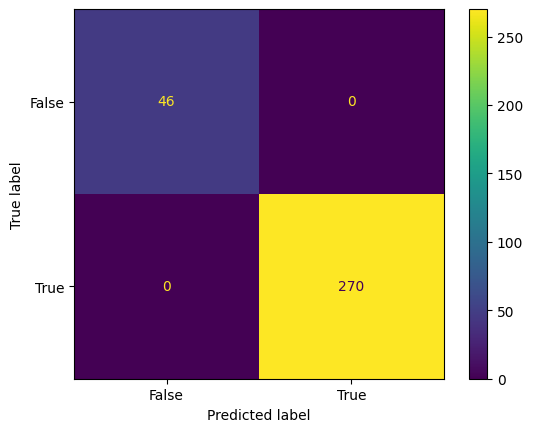

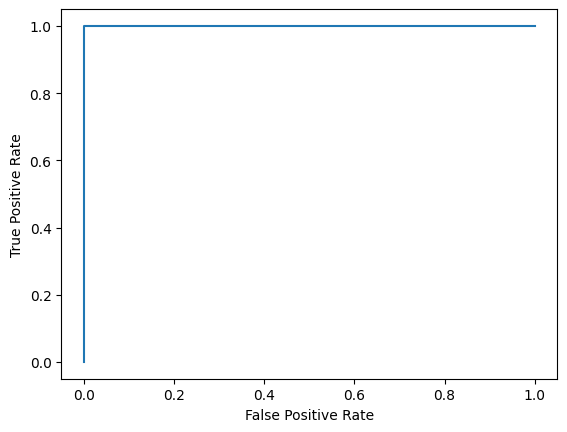

In [41]:
clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)
score(X_test, y_test, best_clf)

Resampled dataset shape Counter({1: 2322, 0: 2322})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


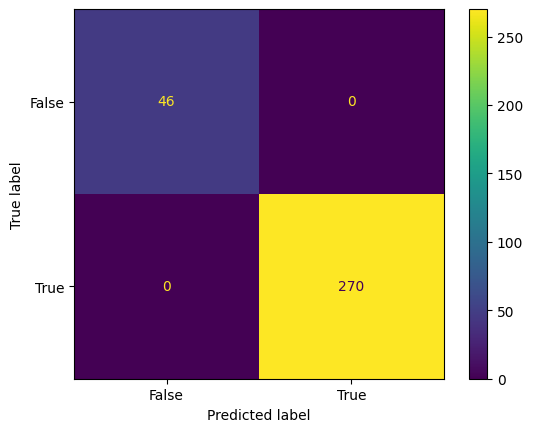

Resampled dataset shape Counter({1: 2322, 0: 2322})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


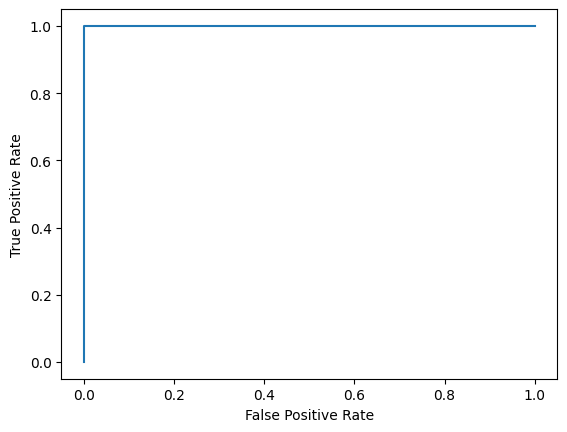

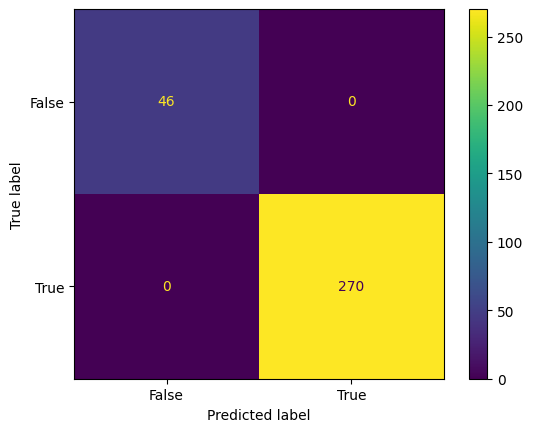

Resampled dataset shape Counter({1: 2322, 0: 2322})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


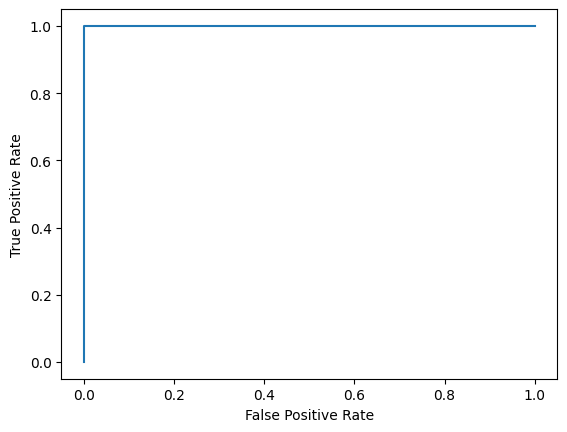

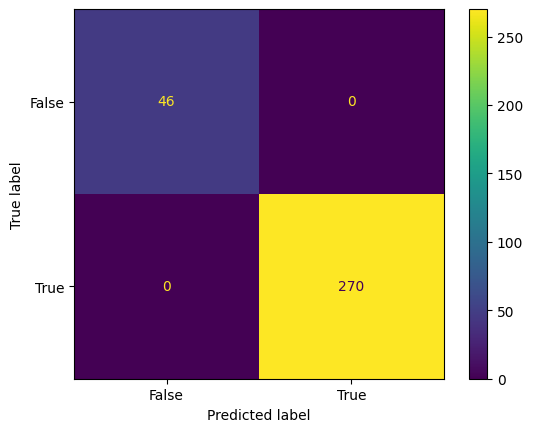

Resampled dataset shape Counter({1: 2322, 0: 2322})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


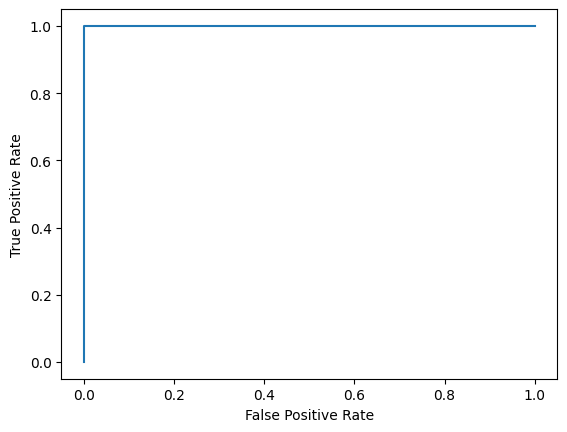

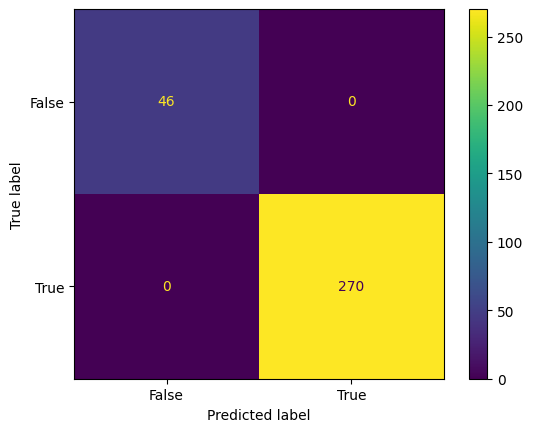

Resampled dataset shape Counter({1: 2322, 0: 2322})
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


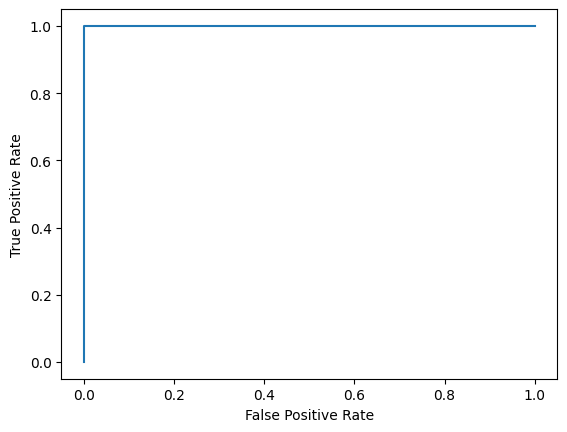

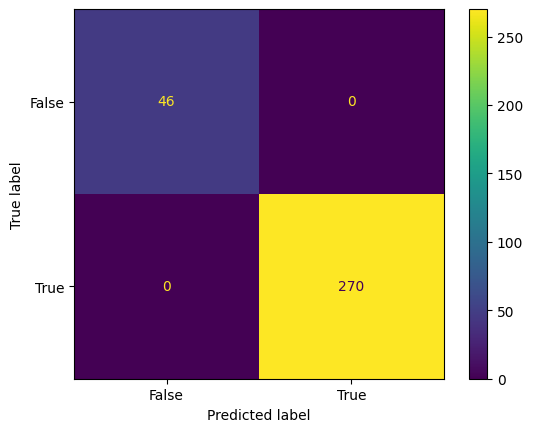

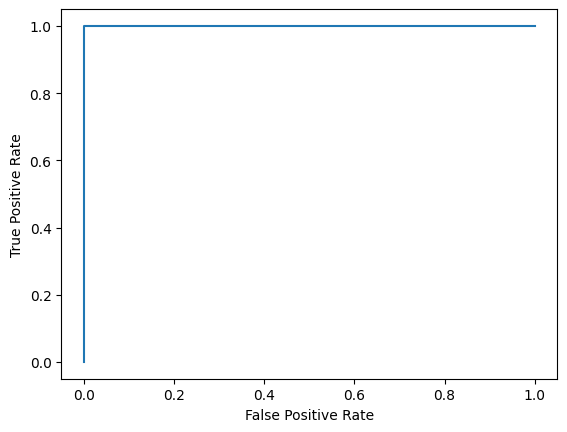

In [42]:
sm_list = []
from collections import Counter
for i in [3, 5, 7, 9, 11]:
    sm_list.append(SMOTE(random_state=42, k_neighbors=i))
for sm in sm_list:
    X_new, y_new = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_new))
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


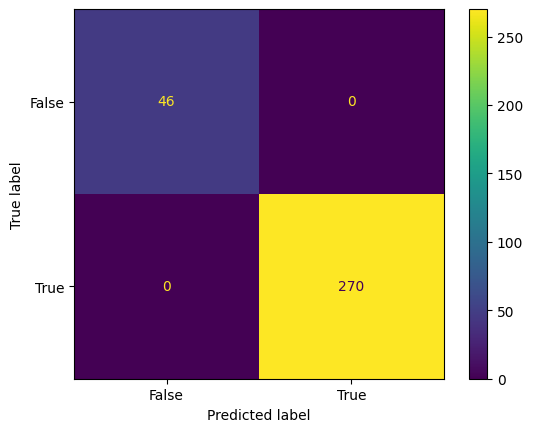

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


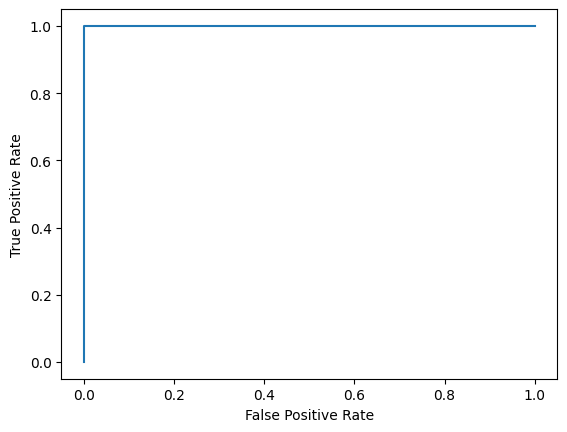

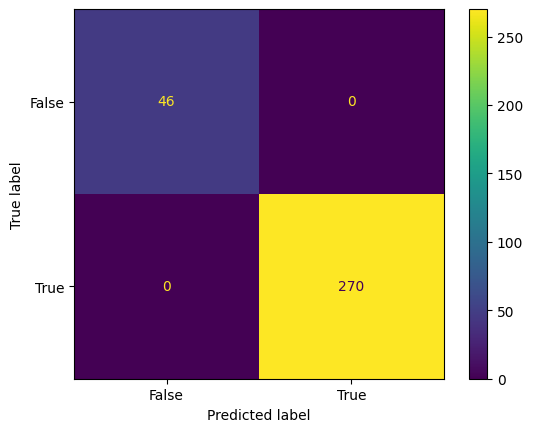

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


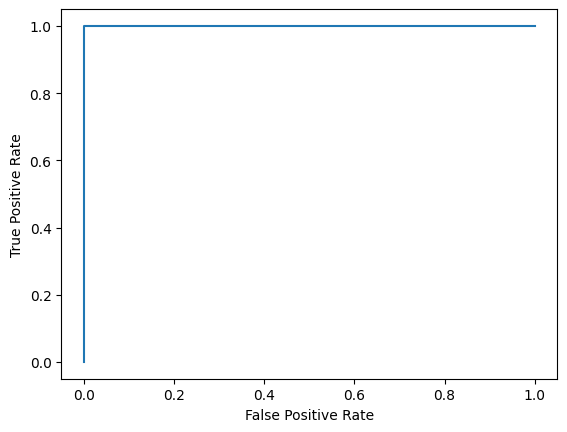

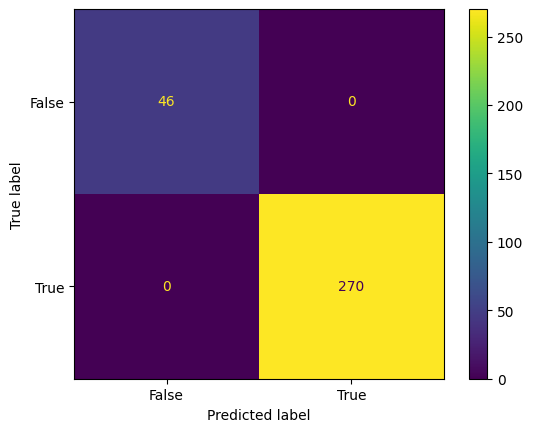

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


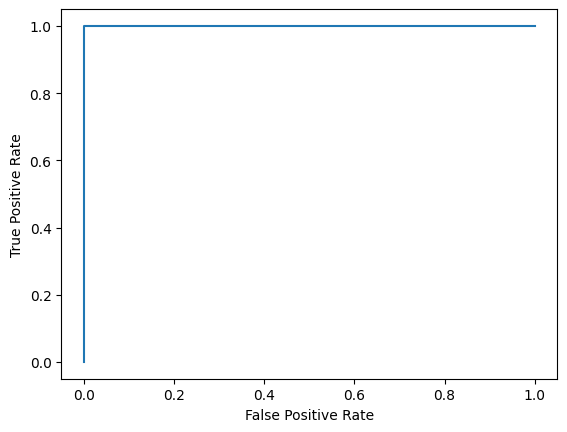

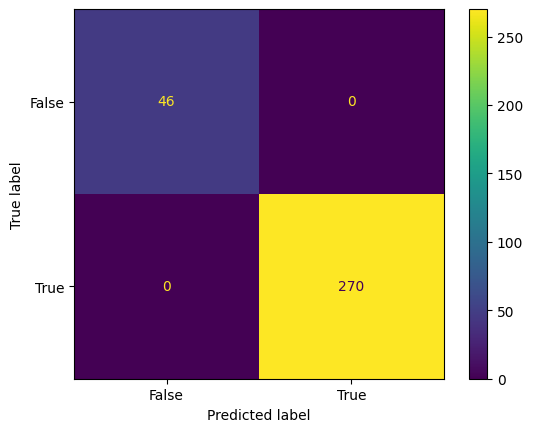

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Accuracy: 1.000000
Error Rate: 0.0
Mean Recall: 1.0
Balanced Accuracy Score: 1.0
Precision: 1.0
F-Score: 1.0
316 316
Selectivity: 1.0
G_mean: 1.0


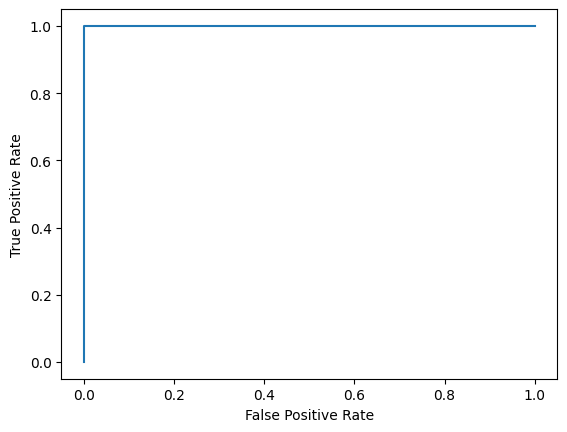

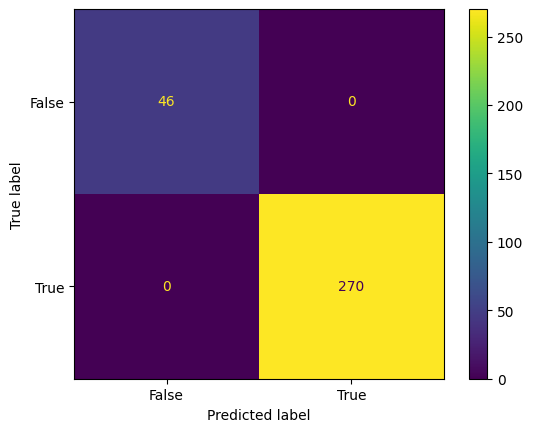

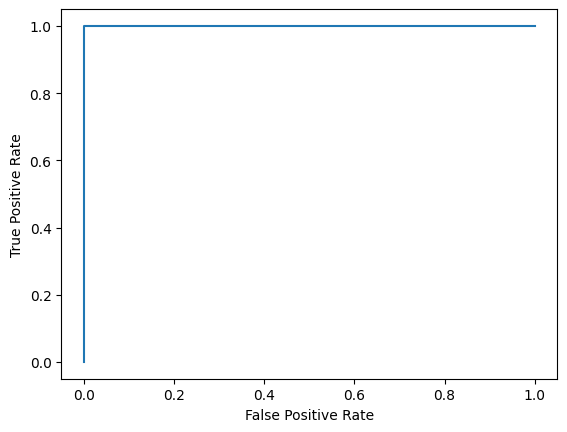

In [43]:
csm_list = []
for (i,j) in [(5,3), (7,3), (9,3), (7,5), (9,7)]:
    csm_list.append(CentroidSMOTE(k_neighbors=i, m_vertices=j))

for csm in csm_list:
    X_new, y_new = csm.fit_resample(X_train, y_train)
    pipeline = Pipeline([
        ('classifier', KNeighborsClassifier())
    ])

    parameters = {
        'classifier__n_neighbors' : [3, 5, 7, 9, 11],
    }

    clf = GridSearchCV(pipeline, param_grid = parameters, cv = 5, verbose=True, n_jobs=-1)
    best_clf = clf.fit(X_new, y_new)
    score(X_test, y_test, best_clf)